# How a Bayesian Shops on Amazon
Alex Sanchez  
June 2020 // Seattle, WA
___

I was catching up with a friend over a drink one evening when the topic of conversation shifted to work. At the time, my friend was working at Amazon as a UX designer and was on a project related to how people interact with the reviews section of a product page. It's a very important part of buying a product on Amazon, but one that's full of noise. Any one review isn't useful on its own and carefully balancing what all the reviews have to say is more work than it's worth. He mentioned that people have different ways they distill the reviews in order to come to a decision; a heuristic that helps them choose one product over another. 

Some people only look at the number of 1-star reviews, some only the number of 5-stars. For me, I liked to add together the percentage of 4 and 5-stars and if it's above 90%, I feel confident in buying. Among all the different tricks people use, one interesting thing stands out: rarely, if ever, does anyone just go by the average rating. Why are we so adverse to using such a strait-forward indicator?

We may not know it, but we're being a little Bayesian in our reasoning for being skeptical of comparing the averages. There are many reasons for this, but the one I'd like to focus on in this article is that it's hard to compare a product which has hundreds of reviews with a product that might only have a few dozen. There's some uncertainty which comes with a product that has less reviews. Taken to the extreme, would you feel confident buying a product which had a perfect 5-start average if there was only one review? Probably not.

I hope to show that we can quantify this uncertainty to form a statistical comparison of two products even though the sample size of reviews is very different. We can even calculate a probability of one product having better reviews than another. Let's imagine we're comparing two printers. One printer, say Printer A,  has better reviews than Printer B, but much fewer of them. We can quantify the uncertainty that comes with less information (i.e. fewer reviews) and use Bayesian analysis to factor in this uncertainty in deciding if Printer A is really better than Printer B.

So we are asking, what is the probability that Printer A is better than Printer B?

## Laying the groundwork

To do a Bayesian analysis we need to compute a probability distribution for each printer, then compare these two distributions to quantify how sure we are that one printer is better than the other. The distributions we're comparing are known as *posteriors* which show the probabilities for each set of parameters that may result in the data we observe. In this case, the parameters are the probabilities of seeing each star category (1 to 5 stars) for each printer and the data is the actual count of 1-star, 2-star, 3-star, 4-star and 5-star reviews each printer recieved.

To get the posterior for each printer I will use an adaptation of Bayes' Rule. Here's Bayes' Rule in its basic form:  

$P$ = probability  
$H$ = hypothesis  
$E$ = evidence  

### $P(H\ |\ E) = \frac{P(E\ |\ H) \ \cdot \ P(H)}{P(E)}$

or

### $posterior = \frac{likelihood \ \cdot \ prior}{P(data)}$

Now, let's adapt it for our specicifc analysis (see [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) for more details):
 
$p$ = probability distribution  
$\theta$ = all possible parameters to the likelihood distribution  
$X$ = data (all the reviews of the printer)  
$\alpha$ = parameters to the prior distribution

### $p(\theta\ |\ X, \alpha) = \frac{p(X\ |\ \theta)\ \cdot\ p(\theta\ |\ \alpha)}{\Sigma ( p(X\ |\ \theta)\ \cdot\ p(\theta\ |\ \alpha) )}$

Keep in mind that each $p$ is a distributution (array) of probabilities across all the values of $\theta$  

In the end we will be comparing two distributions:

### $p(\theta\ |\ X_{printerA}, \alpha) = \frac{p(X_{printerA}\ |\ \theta)\ \cdot\ p(\theta\ |\ \alpha)}{\Sigma(\ p(X_{printerA}\ |\ \theta)\ \cdot\ p(\theta\ |\ \alpha)\ )}$

### $p(\theta\ |\ X_{printerB}, \alpha) = \frac{p(X_{printerB}\ |\ \theta)\ \cdot\ p(\theta\ |\ \alpha)}{\Sigma(\ p(X_{printerB}\ |\ \theta)\ \cdot\ p(\theta\ |\ \alpha)\ )}$

## Beginning the analysis

In [1]:
import matplotlib.pyplot as plt
from typing import Generator
import scipy.stats as stats
import pandas as pd
import numpy as np

## $\theta$
All possible parameters to the likelihood distribution

First, I must generate all the values of $\theta$. In this case, they are the parameters to the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution). The parameters of the multinomial distrubtion are the probabilties of each category and the total number of observations. For doing a Bayesian analysis, we need to consider all the possible multinomial distributions which could generate the data we see for each product review. This means generating all the possible combinations of five probabilities which add to 1.0 (e.g. [.25, .25, .25, .10, .15]). We do this with the code below and generate over 4.5 million combinations!

In [2]:
def make_sums(n: int, total_sum: int) -> Generator[int, None, None]:
    """ 
    Return a generator of all positive integer permutations which add to the 
    supplied total_sum.

    Arguments:
    n -- the number of positive integers in each permutation
    total_sum -- what all the positive itegers should add up to
    """
    if n == 1:
        yield (total_sum,)
    else:
        for value in range(total_sum + 1):
            for permutation in make_sums(n - 1, total_sum - value):
                yield (value,) + permutation

In [3]:
l = list(make_sums(5,100))
parameters = np.array(l)/100

In [4]:
print('Total permutations:', len(parameters))
print('10 sample permutations:')
sample_idxs = np.random.choice(parameters.shape[0], 10)
print(parameters[sample_idxs, :])

Total permutations: 4598126
10 sample permutations:
[[0.37 0.02 0.4  0.19 0.02]
 [0.05 0.24 0.23 0.17 0.31]
 [0.06 0.15 0.44 0.01 0.34]
 [0.43 0.15 0.15 0.16 0.11]
 [0.03 0.26 0.19 0.05 0.47]
 [0.35 0.05 0.03 0.45 0.12]
 [0.12 0.12 0.22 0.28 0.26]
 [0.07 0.15 0.3  0.43 0.05]
 [0.21 0.13 0.22 0.22 0.22]
 [0.5  0.07 0.09 0.2  0.14]]


Now that we have all possible parameters ($\theta$), we just need the data for Printer A and Printer B ($X_{printerA}$ and $X_{printerB}$). The data in this case are the counts for each star category for each printer. Amazon gives use the total number of reviews and the percentage for each star category which we can use to generate the raw data. 

## $X_{printerA}, X_{printerB}$
Data (i.e. reviews) for Printer A and Printer B

In [5]:
data_a = round(pd.Series([.5, .5, 0.0, 0.0, 0.0]) * 4, 0).astype(int).to_list()
data_b = round(pd.Series([.52, .16, .10, .14, .08]) * 100, 0).astype(int).to_list()

print('Printer A star counts', data_a)
print('Printer B star counts', data_b)

Printer A star counts [2, 2, 0, 0, 0]
Printer B star counts [52, 16, 10, 14, 8]


In [6]:
print('Average rating of Printer A: ', np.dot(data_a, [5, 4, 3, 2, 1]) / 4, 'stars')
print('Average rating of Printer B: ', np.dot(data_b, [5, 4, 3, 2, 1]) / 100, 'stars')

Average rating of Printer A:  4.5 stars
Average rating of Printer B:  3.9 stars


## $p(X_{printerA}\ |\ \theta),\ p(X_{printerB}\ |\ \theta)$
The likelihood distribution for Printer A and Printer B

In [7]:
likelihoods_a = stats.multinomial.pmf(x=data_a, n=sum(data_a), p=parameters)
likelihoods_b = stats.multinomial.pmf(x=data_b, n=sum(data_b), p=parameters)

## $\alpha$
The prior distribution's parameters

The prior distribution to the multinomial is the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) (pronounced something like *DEER-ick-lay*). Its function is to give us the proabilities for all the possible parameters that make up $\theta$. If we know that it's very unlikely for a product to get a 2-star rating, we should incorporate that unlikeliness into our posterior. However, if we have no idea what to expect in our review data we can use a prior that treats all possible parameters to the likelihood function as equally likely. This is called a uniform prior and it's what we'll use in the first part of the analysis.

$\alpha$ = (1, 1, 1, 1, 1)  
prior distribution = Dirichlet($\alpha$)

In [8]:
# a uniform, weak prior distribution
alpha = [1, 1, 1, 1, 1]
prior_distribution = stats.dirichlet(alpha)

As we can see below, two random samples from our prior distribution are equally likey 

In [9]:
one_sample = prior_distribution.rvs(1)[0]
another_sample = prior_distribution.rvs(1)[0]

print('A random sample from our uninformed Dirichlet:', one_sample)
print('Another random sample from our uninformed Dirichlet:', another_sample)
print('*****')
print('Relative likelihood of first sample: ', prior_distribution.pdf(one_sample))
print('Relative likelihood of second sample: ', prior_distribution.pdf(another_sample))

A random sample from our uninformed Dirichlet: [0.01280559 0.07547039 0.47073771 0.41845403 0.02253228]
Another random sample from our uninformed Dirichlet: [0.47742101 0.04312001 0.24669598 0.22994945 0.00281355]
*****
Relative likelihood of first sample:  24.000000000000004
Relative likelihood of second sample:  24.000000000000004


## $p(\theta\ |\ \alpha)$
The prior or prior likelihoods

In [10]:
# compute p(theta | alpha) for all thetas
priors = prior_distribution.pdf(parameters.T)

Now that we have the **likelihoods** and **priors**, we just need to multiply them together and divide by the sum of them to get the **posterior**:

## $p(\theta\ |\ X_{printerA}, \alpha),\ p(\theta\ |\ X_{printerB}, \alpha)$
The posterior distribution for Printer A and Printer B

In [11]:
posterior_a = pd.Series( likelihoods_a * priors )
posterior_b = pd.Series( likelihoods_b * priors )

# dividing the sum normalizes the posterior so it sums to 1 as all probabilities should
posterior_a = posterior_a / posterior_a.sum()
posterior_b = posterior_b / posterior_b.sum()

And now I'm done with the Bayesian part of the analysis. What I get are two probability distributions: a posterior for Printer A and posterior for Printer B. Each posterior reflects the likely quality of the printer and the more reviews we have for the printer, the more certain we are of its quality. The posterior is much easier to understand when visualized, but since we have 5 categories to describe each printer (1-5 stars) we are left with a posterior distrbution which exists in 5 dimensions.

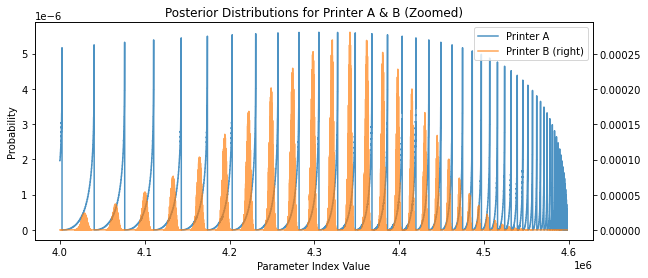

In [12]:
fig, ax = plt.subplots()

posterior_a.loc[4000000:].rename('Printer A').plot(legend=True, figsize=(10,4), ax=ax, alpha=.8);
posterior_b.loc[4000000:].rename('Printer B').plot(title='Posterior Distributions for Printer A & B (Zoomed)', legend=True, ax=ax, secondary_y=True, alpha=.7);

ax.set_xlabel("Parameter Index Value");
ax.set_ylabel("Probability");

While interesting, the chart above isn't very interptrable because the x-axis is just the index (0 - 4.6ish million) of each parameter set in $\theta$. We need to reduce the parameter set from 5 to 1 in order to visualize the posterior. Luckily, our categories are cardinal and can be averaged together to produce a meaningful result. For example, the parameter set (0.5, 0.5, 0.0, 0.0, 0.0) can be converted to a 4.5 average by multplying it by [5, 4, 3, 2, 1] and then summing it up (this is the dot product in linear algebra).

In [13]:
# example converting a theta to a mean star count
np.array([.50, .50, .00, .00, .00]).dot([5, 4, 3, 2, 1])

4.5

Let's use the method above to convert all the parameter sets in $\theta$ to mean star counts

In [14]:
# make a dataframe for each posterior that combine the parameters
# with the correspoding probabilities
posterior_a_avg = pd.concat([pd.DataFrame(parameters), posterior_a.rename('p')], axis=1)
posterior_b_avg = pd.concat([pd.DataFrame(parameters), posterior_b.rename('p')], axis=1)

# convert all of our parameters into averages and round to 2 decimal places
avg_index = round(posterior_a_avg.iloc[:, :5].dot([5,4,3,2,1]), 2)

# set the index as the corresponing parameter avg
posterior_a_avg = posterior_a_avg['p']
posterior_a_avg.index = avg_index
posterior_b_avg = posterior_b_avg['p']
posterior_b_avg.index = avg_index

# group by on the index and sum to combine duplicate avgs
posterior_a_avg = posterior_a_avg.groupby(level=0).sum()
posterior_b_avg = posterior_b_avg.groupby(level=0).sum()

## 2-D Visualization of the posteriors

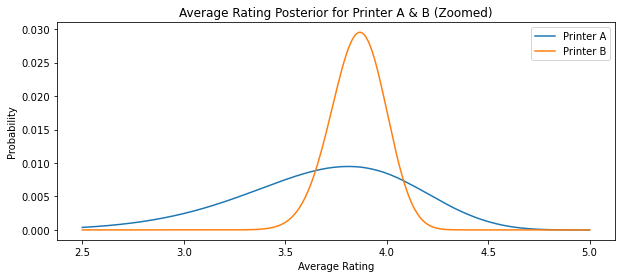

In [15]:
fig, ax = plt.subplots()


posterior_a_avg.rename('Printer A').loc[2.5:].plot(title='Average Rating Posterior for Printer A & B (Zoomed)', 
                                          ax=ax,
                                          legend=True,
                                          figsize=(10,4))
posterior_b_avg.rename('Printer B').loc[2.5:].plot(ax=ax, legend=True);

ax.set_xlabel("Average Rating");
ax.set_ylabel("Probability");

A thing of beauty, isn't it? The peak of each posterior represents the most likely average rating while the spread of the curve (variance) represents the uncertaintly. Since we have more reviews for Printer B, we are more certain of its true average rating. The last thing we have left to do is compute the probability that Printer A is better than Printer B.

To find this probability we need to compute the joint probability of both posteriors then sum all the probabilities in the area where A's rating is greater than B's. This gets a little tricky because we have to compute probabilities for all the possible combinations of A and B's average rating. This means that our joint probability will actually be a three dimensional curve where the x-axis is the average rating for Printer A, the y-axis is the average rating for printer B and z-axis is the joint probability.

In [16]:
# a lot going on here. note that B is transposed in line 7; creating an alignment for 
# all possible outcomes when A and B are multiplied
a_joint = pd.DataFrame([posterior_a_avg.to_list()]*posterior_a_avg.shape[0])
b_joint = pd.DataFrame([posterior_b_avg.to_list()]*posterior_b_avg.shape[0])

# assuming independence
joint_probability =  a_joint * b_joint.T

# normailze our joint distribution so all possible outcomes sum to 1
joint_probability = joint_probability / joint_probability.sum().sum()

The joint probability distribution for Keyboard A and B's average rating visualized in three dimensions:

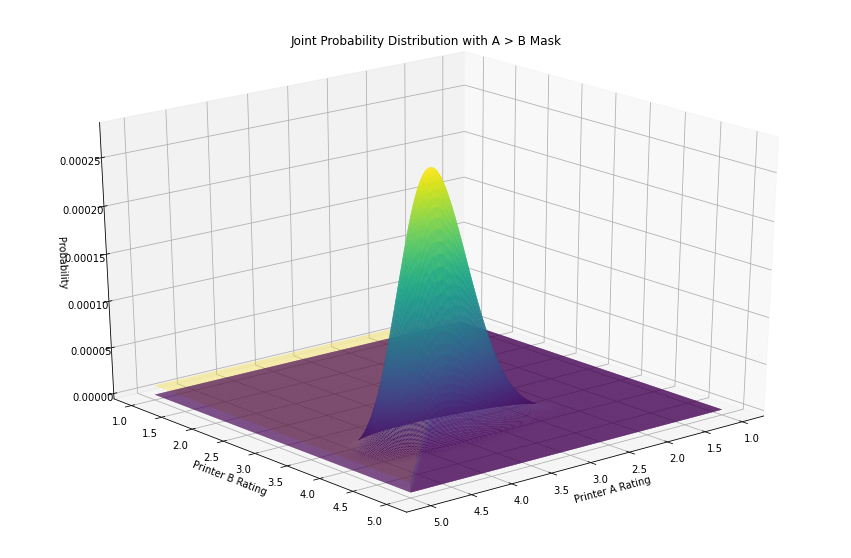

In [17]:
# visualizing the joint distribution with the A > B mask
fig, ax = plt.subplots(figsize=(15,10))

# create the necessary X, Y values
X, Y = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))

# create the Z values for the mask
# in this case a slight step in the 3d plot
a_gt_b_mask_plt = np.zeros(shape=X.shape)
a_gt_b_mask_plt[np.where(X > Y)] = .00001

ax = plt.axes(projection='3d')

# joint probability plot
ax.plot_surface(X, Y, joint_probability.values, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=1);

# mask plot
ax.plot_surface(X, Y, a_gt_b_mask_plt, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=.4);

ax.set_title('Joint Probability Distribution with A > B Mask');
ax.set_xlabel("Printer A Rating");
ax.set_ylabel("Printer B Rating");
ax.set_zlabel("Probability");

elevation = 25
azimuth = 50
ax.view_init(elevation, azimuth)

In the plot above, we see the joint distribution in all three dimensions. The half of the floor which is shaded lighter represents the area where Printer A's average rating is greater than Printer B's. It looks like most of the joint probability curve falls outside of the shaded area which tells us that Printer A is probably *not* better than Printer B even though it has a higher average rating on Amazon.

Let's compute the actual probability:

In [18]:
# create a mask to filter out all scenarios where A's ratings are less than B's
# some of this was defined above, but I'm doing it again for clarity
ratings_A, ratings_B = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))
a_gt_b_mask = np.zeros(shape=X.shape)
a_gt_b_mask[np.where(ratings_A > ratings_B)] = 1.0

In [19]:
# apply the mask to our joint probability; leaving us only with probabilities
# where A > B then add them up to determine the final probability
p = (a_gt_b_mask * joint_probability).sum().sum()
print('Probability that Printer A has better ratings than Printer B:', round(p, 4))

Probability that Printer A has better ratings than Printer B: 0.3748


Using Bayesian analysis and some statisitcs I've been able to show that, even though Printer A has a better average rating on Amazon, we have more justification in choosing Printer B because we are only 37.5% sure that Printer A is better. 

That is how a Bayesian shops on Amazon.

___

## A Note On Choosing The Prior
There is some subjectivity in this analysis and Bayesian analysis in general. Had I not chose a weak, uniform prior, the analysis could have turned out much differently. Let's consider an alternative prior based on each printer's brand's performance.

### Prior parameter ($\alpha$) based on each printer's brand ratings

Let's say Printer A comes from a very reputable brand which sells five other products on Amazon and we thihnk that we should take those other products reviews into account for Printer A's posterior

In [20]:
brandA_1 = round(pd.Series([.85, .05, .05, .05, .00]) * 100, 0).astype(int)
brandA_2 = round(pd.Series([.90, .08, .02, .00, .00]) * 79, 0).astype(int)
brandA_3 = round(pd.Series([.91, .05, .02, .00, .01]) * 56, 0).astype(int)
brandA_4 = round(pd.Series([.86, .10, .00, .00, .04]) * 145, 0).astype(int)
brandA_5 = round(pd.Series([.89, .01, .05, .02, .03]) * 32, 0).astype(int)

stronger_alpha_a = list(np.array((brandA_1 + brandA_2 + brandA_3 + brandA_4 + brandA_5) / 50) + 1)
print('New prior parameters for Printer A:', stronger_alpha_a)

New prior parameters for Printer A: [8.2, 1.56, 1.2, 1.12, 1.16]


Let's say Printer B's brand has 2 other products which aren't rated as high as Printer A's brand

In [21]:
brandB_1 = round(pd.Series([.75, .10, .05, .05, .05]) * 100, 0).astype(int)
brandB_2 = round(pd.Series([.70, .15, .01, .00, .14]) * 79, 0).astype(int)

stronger_alpha_b = list(np.array((brandB_1 + brandB_2) / 20) + 1)
print('New prior parameters for Printer B:', stronger_alpha_b)

New prior parameters for Printer B: [7.5, 2.1, 1.3, 1.25, 1.8]


In [22]:
stronger_prior_dist_a = stats.dirichlet(stronger_alpha_a)
stronger_prior_dist_b = stats.dirichlet(stronger_alpha_b)
new_priors_a = stronger_prior_dist_a.pdf(parameters.T)
new_priors_b = stronger_prior_dist_b.pdf(parameters.T)

posterior_a = pd.Series( likelihoods_a * new_priors_a )
posterior_b = pd.Series( likelihoods_b * new_priors_b )
posterior_a = posterior_a / posterior_a.sum()
posterior_b = posterior_b / posterior_b.sum()

posterior_a_avg = pd.concat([pd.DataFrame(parameters), posterior_a.rename('p')], axis=1)
posterior_b_avg = pd.concat([pd.DataFrame(parameters), posterior_b.rename('p')], axis=1)

avg_index = round(posterior_a_avg.iloc[:, :5].dot([5,4,3,2,1]), 2)

posterior_a_avg = posterior_a_avg['p']
posterior_a_avg.index = avg_index
posterior_b_avg = posterior_b_avg['p']
posterior_b_avg.index = avg_index

posterior_a_avg = posterior_a_avg.groupby(level=0).sum()
posterior_b_avg = posterior_b_avg.groupby(level=0).sum()

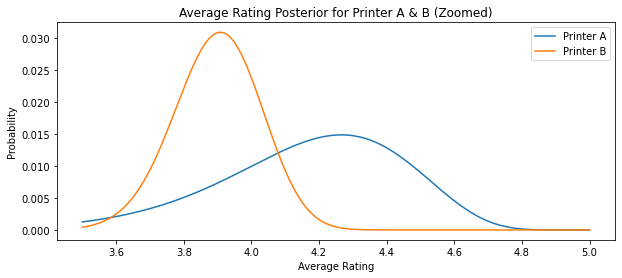

In [23]:
fig, ax = plt.subplots()


posterior_a_avg.rename('Printer A').loc[3.5:5].plot(title='Average Rating Posterior for Printer A & B (Zoomed)', 
                                                     ax=ax,
                                                     legend=True,
                                                     figsize=(10,4))
posterior_b_avg.rename('Printer B').loc[3.5:5].plot(ax=ax, legend=True);

ax.set_xlabel("Average Rating");
ax.set_ylabel("Probability");

In the graph above, notice that the posterior for Printer A is slightly steeper and more skewed once we added a stronger prior based on other products sold by Printer A's brand. Having more information going into our analysis can make the results of it more certain.

In [24]:
a_joint = pd.DataFrame([posterior_a_avg.to_list()]*posterior_a_avg.shape[0])
b_joint = pd.DataFrame([posterior_b_avg.to_list()]*posterior_b_avg.shape[0])

joint_probability =  a_joint * b_joint.T

joint_probability = joint_probability / joint_probability.sum().sum()

ratings_A, ratings_B = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))
a_gt_b_mask = np.zeros(shape=X.shape)
a_gt_b_mask[np.where(ratings_A > ratings_B)] = 1.0

p = (a_gt_b_mask * joint_probability).sum().sum()
print('Probability that Printer A has better reviews than Printer B:', round(p, 4))

Probability that Printer A has better reviews than Printer B: 0.8115


Printer A now has a 81.15% probability of being a better printer. It's important we see that our choice of a different prior distribution had a significant impact on the results of our analysis. It should always be done thoughtfully and made explicit so everyone has a better context for the results.

Below, I have included a 3-D graph of the joint probability distribution as well for comparison. You can see that the differences are analagous to the differences we saw in the posterior distributions:

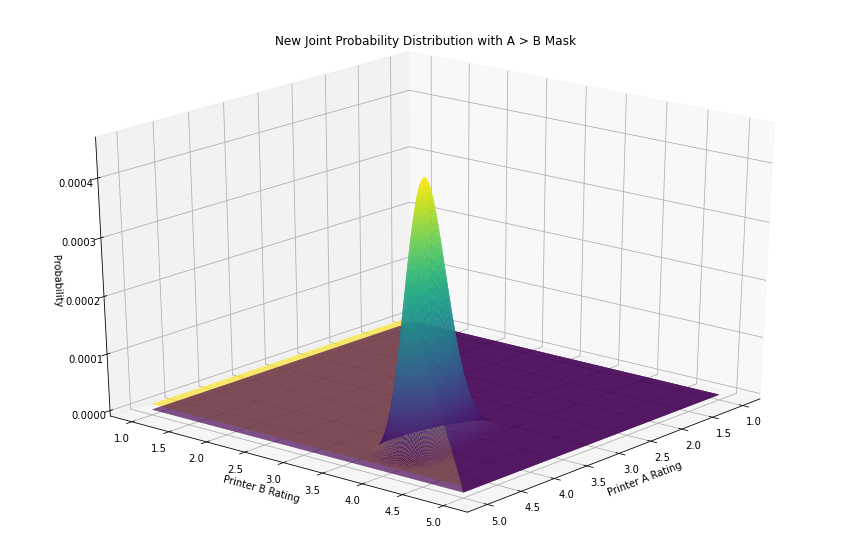

In [25]:
fig, ax = plt.subplots(figsize=(15,10))

X, Y = np.meshgrid(np.linspace(1,5, 401), np.linspace(1,5,401))

a_gt_b_mask_plt = np.zeros(shape=X.shape)
a_gt_b_mask_plt[np.where(X > Y)] = .00001

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, joint_probability.values, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');

ax.plot_surface(X, Y, a_gt_b_mask_plt, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');

ax.set_title('New Joint Probability Distribution with A > B Mask');
ax.set_xlabel("Printer A Rating");
ax.set_ylabel("Printer B Rating");
ax.set_zlabel("Probability");

elevation = 25
azimuth = 40
ax.view_init(elevation, azimuth)

## So, who cares?

The main utility of this analysis is to show how you can place a quanitifible value on uncertainty and bias. As a data scientist, I need to justify the decisions I make with data to both cover me in case something goes wrong, but also to gain buy-in from others if they're making the decision with me.

This form of analysis also comes in handy when I need to consider *when* to make a decision. Instead of printers, let's say A and B are companies I want to invest in. If Company A is reporting higher profits, but is very new, I might want to know at what point Company A's performance has overcome its uncertaintly to make it a better investment than Company B.

Lastly, Bayesian analysis allows you to define thresholds for confidence before making important decisions. If this descion I'm making is very risky I might require that I be 99% sure that one alternative is better than the other before making a decision.